# CHySwash Methodology

Coastal regions worldwide face increasing threats from rising sea levels and intensified storm events, leading to accelerated erosion and heightened flood risks. Intertidal ecosystems, such as mangroves and salt marshes, have been recognized for their potential to mitigate these impacts through wave energy attenuation. However, accurately quantifying their protective capacity remains a challenge due to the complex interplay of hydrodynamic and ecological factors. 


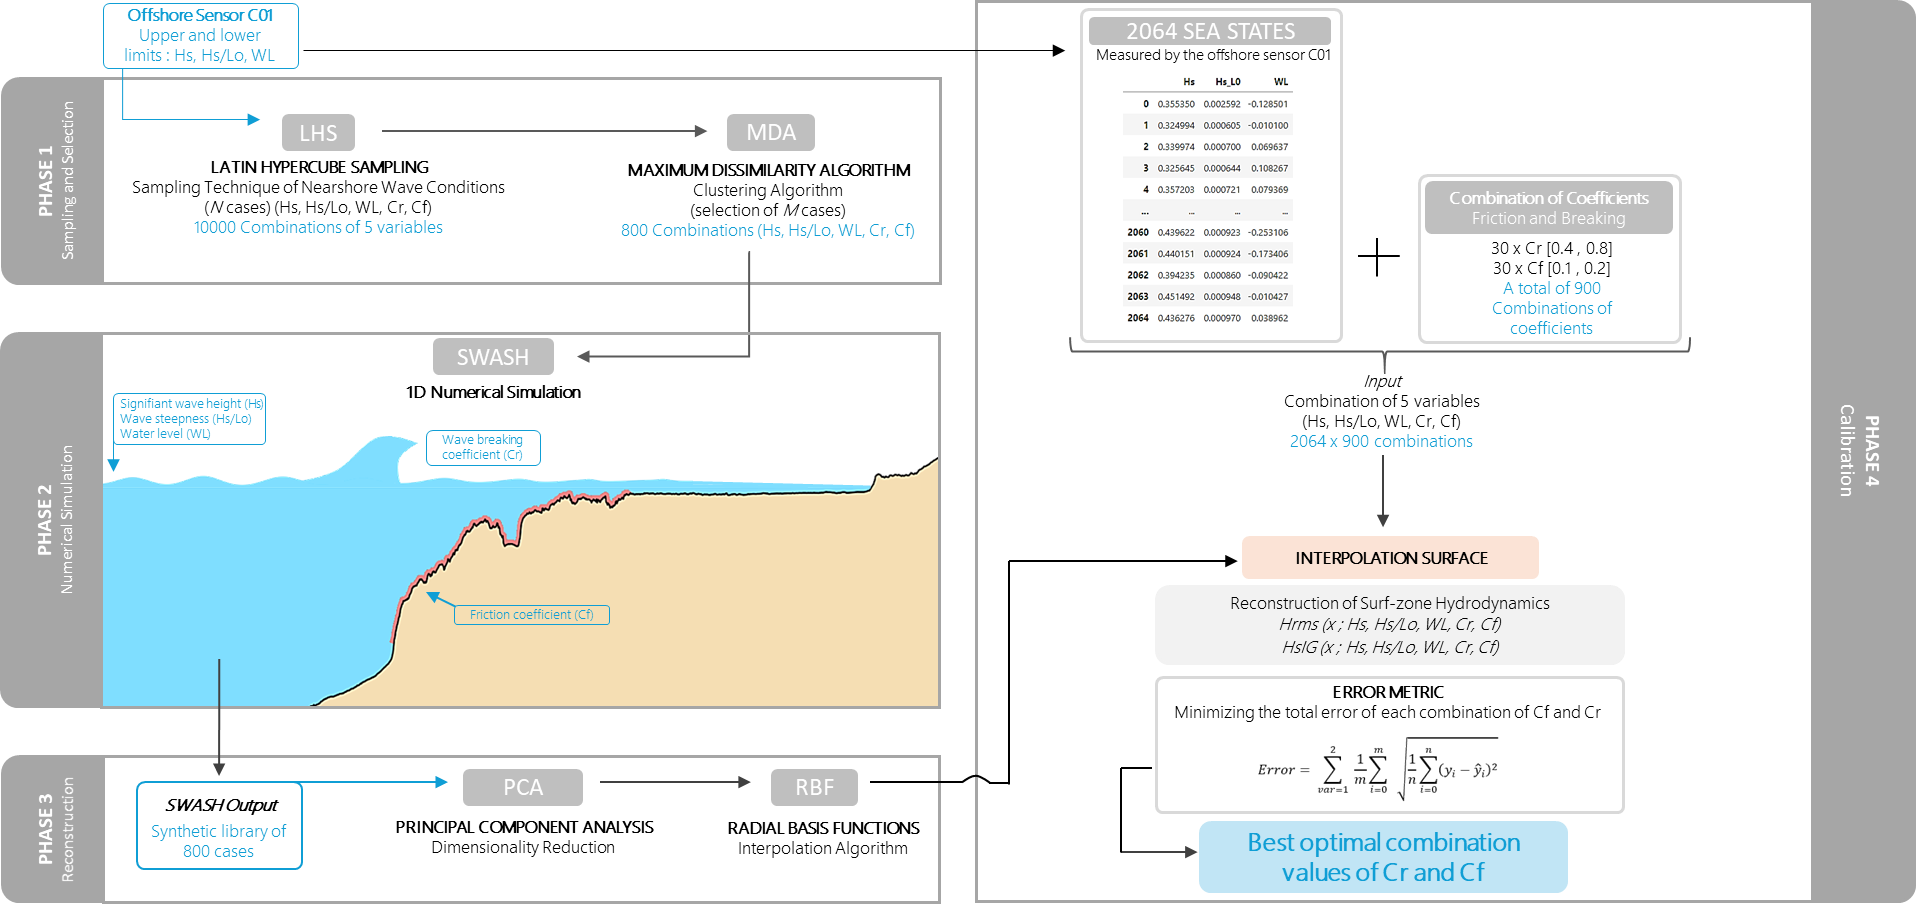

## Variable Selection and Sampling
### Variable Selection
It is essential to carefully select the variables that will feed into the presented metamodel. The numerical model SWASH (Simulating WAves till SHore) is designed to solve the Navier-Stokes equations numerically, relying on key hydrodynamic input variables. Drawing from previous research on hydrodynamic modeling, it has been proven that the necessary variables encompass :
- Significant wave height (Hs)
- Wave slope (Hs/L0)
- Offshore water level (WL)

However, when it comes to simulating the complex process of wave breaking in the nearshore zone, SWASH requires additional inputs to accurately reflect real-world conditions. The model alone cannot determine these parameters, necessitating user-defined inputs. Therefore, we also include the two critical coefficients responsible for governing wave breaking and energy dissipation: 
- Wave breaking coefficient (Cr)
- Seabed friction coefficient (Cf)

Proper calibration of these coefficients is crucial for the model to realistically simulate wave behavior and energy dissipation in coral reef environments.

The first step in implementing our metamodel involves generating and selecting specific representative cases that combine the variables previously identified. These combinations will accurately simulate realistic sea states in SWASH. Therefore, our task is to create realistic combinations of these variables to feed into the numerical model later on.
### Latin Hypercube Sampling (LHS)
The Latin Hypercube Sampling (LHS) is a statistical technique designed to efficiently select parameter values across multiple dimensions while ensuring controlled randomness in the sampled data. To implement this technique, we start by establishing the limits for each variable.


In [6]:
import os
import os.path as op

import numpy as np

from bluemath_tk.wrappers.swash.swash_wrapper import ChySwashModelWrapper

import sys

sys.path.insert(0, "..")
from utils.plotting import plot_depthfile

# Define the output directory.
root_dir = os.getcwd()
output_dir = op.join(
    root_dir, "output"
)  # CHANGE THIS TO YOUR DESIRED OUTPUT DIRECTORY!
templates_dir = op.join(root_dir, "templates")
export_dir = op.join(root_dir, "ChySwash_exported")

os.environ["OMP_NUM_THREADS"] = "1"

In [7]:
# LHS
from bluemath_tk.datamining.lhs import LHS

variables_to_analyse_in_metamodel = ["Hs", "Hs_L0", "WL", "Cf", "Cr"]
lhs_parameters = {
    "num_samples": 10000,
    "dimensions_names": variables_to_analyse_in_metamodel,
    "lower_bounds": [0.15, 0.0005, -0.6, 0.025, 0.4],
    "upper_bounds": [1.6, 0.009, 0.356, 0.2, 0.8],
}


lhs = LHS(num_dimensions=len(variables_to_analyse_in_metamodel))
df_dataset = lhs.generate(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
    num_samples=lhs_parameters.get("num_samples"),
)
# lhs.plot_generated_data()

/opt/conda/lib/python3.12/importlib/__init__.py:131: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)


### Maximum Dissimilarity Algorithm (MDA)

The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v_{1}}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.  


/opt/conda/lib/python3.12/importlib/__init__.py:131: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)


(<Figure size 640x480 with 10 Axes>,
 array([[<Axes: xlabel='Hs_L0', ylabel='Hs'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: xlabel='WL', ylabel='Hs_L0'>, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='Cf', ylabel='WL'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Cr', ylabel='Cf'>]],
       dtype=object))

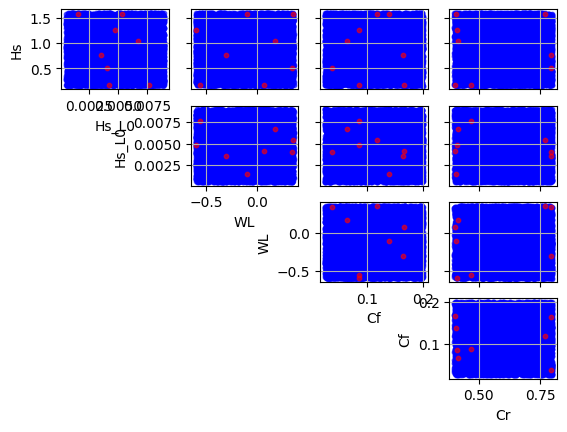

In [8]:
from bluemath_tk.datamining.mda import MDA

# MDA
mda_parameters = {"num_centers": 8}
mda = MDA(num_centers=mda_parameters.get("num_centers"))
mda.fit(data=df_dataset)
metamodel_parameters = mda.centroids.to_dict(orient="list")
mda.plot_selected_centroids()

## SWASH cases execution

Once the hydrodynamic cases to be numerically simulated have been selected through the MDA algorithm, we proceed to launch these cases in SWASH. It is a versatile numerical tool designed to simulate a non-hydrostatic, phase-resolving wave model capable of simulating waves from deep waters to the shoreline, modeling wave breaking, bottom friction, wave- induced setup and runup, and the generation and propagation of infragravity waves (Delft University of Technology, n. d.).

Model boundaries should be far enough from the area of interest and away from steep topography to avoid unrealistic frictional or numerical dispersion effects but close enough to remain computationally feasible kh < 5. As a recommendation, the area of interest should be kept at least two wave lengths away from the boundary. In the following cells, different input choices for defining the cross-shore profile will be given. 
 
* `dxL`  : number of nodes per wavelength. This command sets the grid resolution from the number of nodes desired per wavelength in 1m depth (assuming that in the beach due to the infragravigity waves the water colum can reach 1m heigh). 

* `dxinp`: The resolution of the bathymetric grid is not the same as that of the computational grid. It is advised to avoid extremely steep bottom slopes or sharp obstacles as much as posible. 

Land points are defined as negative while wet points are defined as positive.

### Coral Friction
SWASH allows users to activate bottom friction, and in the default option, the Manning’s coefficient is considered. Our next step is to assign the friction coefficient to the specific zones within the computational grid of SWASH.

The friction coefficient values selected by the MDA, representing the coral friction coefficient for each case, need to be applied accurately. To do this, we must first identify the areas of the reef profile covered by coral structures. Using the Allen Coral Atlas (Allen Coral Atlas, n.d.), we can access the benthic map of the study area, which provides detailed information on the seabed's distribution and characteristics. This data enables us to establish the start and end points of the coral structures within our cross-shore profile.

The Allen Coral Atlas benthic map also offers information about the seabed for the remainder of the profile, identifying sandy areas in the offshore zone and rocky areas in the reef flat zone. However, our focus is not on characterizing the friction coefficient for these regions. Therefore, **we will apply the Cf only to the coral-covered region and use the SWASH default bottom friction value of 0.002 (Delft University of Technology, n.d.) for the rest of the grid profile**.

### Boundary conditions 
The boundaries of the computational grid in SWASH are either land, beach or water. The wave condition is imposed on the west boundary of the computational domain, so that the wave propagation is pointing eastward. To simulate entering waves without some reflections at the wavemaker boundary, a weakly-reflective boundary condition allowing outgoing waves is adopted. For this test case, a time series synthesized from parametric information (wave height, period, etc.) will be given as wavemaker. Here, the wavemaker must be defined as irregular unidirectional waves by means of 1D spectrum. Both the initial water level and velocity components are set to zero.

### Sea states
Once the representative M cases defining our model are selected, we proceed to calculate the different sea states of the waves at the start of the profile using a single-peaked unidirectional TMA spectrum. The TMA spectrum is a generalized version of the JONSWAP spectrum for offshore waves and is valid for waters of any depth. It was designed to modify the spectral shape as water depth decreases, limiting the energy of low-frequency waves in shallower waters.

### User parametes:

* `Nonhydrostatic` : to include the non-hydrostatic pressure in the shallow water equations. Hydrostatic pressure assumption can be made in case of propagation of long waves, such as large-scale ocean circulations, tides and storm surges. This assumption does not hold in case of propagation of short waves, flows over a steep bottom, unstable stratified flows, and other small-scale applications where vertical acceleration is dominant 
* `vert` : this command set the number of vertical layers in case that the run will be in multi-layered mode 

Input waves definition at `waves.py`: <br>
series_regular_monochromatic, series_regular_bichromatic <br>
series_Jonswap, series_TMA <br>
series_Jonswap_bimiodal, series_TMA_bimodal

The user can optionally specify wind speed, direction and wind drag assuming constant values in the domain. As the test case is using cartesian coordinates, please set the direction where the wind cames from.

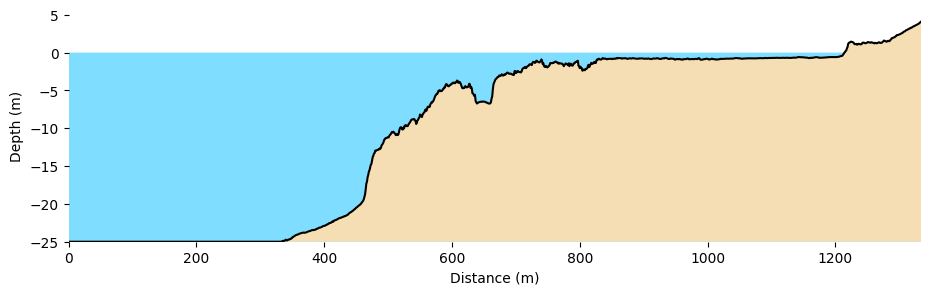

In [9]:
plot_depthfile(depthfile=op.join(templates_dir, "depth.bot"))

In [10]:
fixed_parameters = {
    "dxinp": 1.5,  # bathymetry grid spacing
    "default_Cf": 0.002,  # Friction manning coefficient (m^-1/3 s)
    "Cf_ini": 700 / 1.5,  # Friction start cell
    "Cf_fin": 1250 / 1.5,  # Friction end cell
    "comptime": 7200,  # Simulation duration (s)
    "warmup": 7200 * 0.15,  # Warmup duration (s)
    "n_nodes_per_wavelength": 60,  # number of nodes per wavelength
}

# ChySwashModelWrapper
swash_wrapper = ChySwashModelWrapper(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=np.loadtxt(op.join(templates_dir, "depth.bot")),
)

/opt/conda/lib/python3.12/importlib/__init__.py:131: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2025-05-30 12:10:44,494 - ChySwashModelWrapper - WARNING - Parameter Cf is not in the default_parameters
2025-05-30 12:10:44,495 - ChySwashModelWrapper - WARNING - Parameter Cr is not in the default_parameters


## Build and run all cases

In [12]:
swash_wrapper.build_cases(mode="one_by_one")

In [ ]:
# Launch the model using sbatch
swash_wrapper.run_cases_bulk(
    launcher="sbatch --array=0-799 /home/grupos/geocean/valvanuz/HySwash/SlurmChy.sh"
)

Check output cases status


In [13]:
swash_wrapper.monitor_cases()

,Case,Status
0,0000,No run.tab
1,0001,No run.tab
2,0002,No run.tab
3,0003,No run.tab
4,0004,No run.tab
5,0005,No run.tab
6,0006,No run.tab
7,0007,No run.tab


## Data Postprocessing
The primary output variable generated by SWASH include the time series of water level along the profile. This output serves as crucial indicator of the hydrodynamic processes impacting the reef. From this SWASH output, we compute various other key variables. Different output quantities will be given here to go over the different wave transformation processes including wave propagation, dispersion, flooding and drying, moving shoreline, surf-beat, infragravity waves, set-up induced by wave breaking, run-up and overtopping discharge. 

- To this end, the time-dependent surface elevation is stored at every grid point for every time step. After removing the warmup time from the sea surface series, a FFt is applied to obtain its representation in the frequency domain. A further classification is given by spliting the wave frequency into incident waves IC (0.04 - 1), infragravity waves IG (0.004 - 0.04) and very low frequency VLF (0.001 - 0.004). 

- The run-up heigh is computed by the intersection between free surface and bottom level considering a minimun  depth of 1cm after each time step. 

- The mean wave overtopping discharge q (ms/l) is outputted at the highest elevation point.

Variables:
- `Hrms`
- `Hfreqs` Hs, Hss, Hig, Hvlf
- `Ru2`
- `Msetup`
- `RuDist`

In [ ]:
# Post-process the output files
b = swash_wrapper.list_available_postprocess_vars()
# b = ['Ru2', 'RuDist', 'Msetup', 'Hrms', 'Hfreqs', 'Watlev']
vars_to_postprocess = ["Msetup", "Hrms", "Hfreqs"]

# Post-process the output files for case 0
# postprocessed_0 = swash_wrapper.postprocess_case(583,case_dir="/home/grupos/geocean/valvanuz/HySwash/Chy_cases/0583/",output_vars=vars_to_postprocess)
postprocessed = swash_wrapper.postprocess_cases(output_vars=vars_to_postprocess)
postprocessed

2025-04-15 14:11:19,104 - ChySwashModelWrapper - WARNING - Output postprocessed file already exists. Skipping postprocessing.


<xarray.Dataset> Size: 75MB
Dimensions:   (case_num: 783, Xp: 2002)
Coordinates:
  * Xp        (Xp) int64 16kB 0 1 2 3 4 5 6 ... 1996 1997 1998 1999 2000 2001
    Yp        int64 8B ...
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 793 794 795 796 797 798 799
Data variables:
    Msetup    (case_num, Xp) float64 13MB ...
    Hrms      (case_num, Xp) float64 13MB ...
    Hs        (case_num, Xp) float64 13MB ...
    Hss       (case_num, Xp) float64 13MB ...
    ig        (case_num, Xp) float64 13MB ...
    Hvlf      (case_num, Xp) float64 13MB ...

Export MDA object to be used in ChySwash_analize Notebook

In [ ]:
mda.save_model(model_path=op.join(export_dir, "mda_model.pkl"))